In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import tensorflow as tf

class DAE(object):

	"""
	Denoising autoencoder. Gaussian noise is added. The scale and standard deviation
	of it are noise_scale and noise_std, respectively.
	"""

	def __init__(self, n_feature, n_hidden, noise_scale, noise_std, reg_lamda = 0.01):

		self.n_hidden = n_hidden
		self.n_feature = n_feature
		self.reg_lamda = reg_lamda
		self.noise_scale = noise_scale
		self.noise_std = noise_std

		self.data = tf.placeholder(shape = [None, n_feature],
		                           dtype = tf.float64)
		self.noise = self.noise_scale * tf.random_normal([n_feature], dtype = tf.float64,
		                                               stddev = self.noise_std)
		data_with_noise = self.data + self.noise

		self.weight_encoder = tf.get_variable(name = 'weight_encoder', 
			                    shape = [self.n_feature, self.n_hidden],
			                    dtype = tf.float64)
		self.bias_encoder = tf.Variable(tf.zeros([self.n_hidden], 
			                                      dtype = tf.float64),
		                                name = 'bias_encoder')

		weight_decoder = tf.get_variable(name = 'weight_decoder', 
			                    shape = [self.n_hidden, self.n_feature],
			                    dtype = tf.float64)
		bias_decoder = tf.Variable(tf.zeros([self.n_feature], dtype = tf.float64),
			                           name = 'bias_decoder')

		with tf.name_scope('Encoder'):
			data_encoded = tf.add(tf.matmul(data_with_noise, self.weight_encoder),
				                  self.bias_encoder)
			data_encoded = tf.nn.tanh(data_encoded)

		with tf.name_scope('Decoder'):
			data_recons = tf.add(tf.matmul(data_encoded, weight_decoder),
				                 bias_decoder)
			self.data_recons = tf.tanh(data_recons)

		with tf.name_scope('Loss'):
			diff = self.data_recons - self.data
			self.loss_mse = 0.5 * tf.reduce_mean(tf.reduce_sum(diff**2, axis = 1))
			loss_reg = tf.reduce_sum(tf.sqrt(tf.reduce_sum(self.weight_encoder ** 2, axis = 1))) 
			self.loss_reg = self.reg_lamda * loss_reg
			self.l2_loss = tf.nn.l2_loss(weight_decoder) * 1E-3

			self.loss = self.loss_mse + self.loss_reg + self.l2_loss

		with tf.name_scope('weight_vector'):
			self.weight_vector = tf.reduce_sum(self.weight_encoder ** 2, axis = 1)


class unbalanced_DAE(object):

	"""
	An unbalanced version of DAE. the differences is that a weight pos_weight is added
	to the MSE reconstruction loss for positive examples. For this purpose, the labels
	of the examples are used.
	"""
	
	def __init__(self, n_feature, n_hidden, noise_scale, noise_std,
	             posi_weight = 1.0, reg_lamda = 0.00):

		self.n_hidden = n_hidden
		self.n_feature = n_feature
		self.reg_lamda = reg_lamda
		self.noise_scale = noise_scale
		self.noise_std = noise_std
		self.posi_weight = posi_weight

		self.data = tf.placeholder(shape = [None, n_feature], dtype = tf.float64)
		self.label = tf.placeholder(shape = [None, 1], dtype = tf.float64)
		self.noise = self.noise_scale * tf.random_normal([n_feature], dtype = tf.float64,
		                                                  stddev = self.noise_std)
		data_with_noise = self.data + self.noise

		self.weight_encoder = tf.get_variable(name = 'weight_encoder', 
			                    shape = [self.n_feature, self.n_hidden],
			                    dtype = tf.float64)
		self.bias_encoder = tf.Variable(tf.zeros([self.n_hidden], 
			                                      dtype = tf.float64),
		                                name = 'bias_encoder')

		weight_decoder = tf.get_variable(name = 'weight_decoder', 
			                    shape = [self.n_hidden, self.n_feature],
			                    dtype = tf.float64)
		bias_decoder = tf.Variable(tf.zeros([self.n_feature], dtype = tf.float64),
			                           name = 'bias_decoder')

		with tf.name_scope('Encoder'):
			data_encoded = tf.add(tf.matmul(data_with_noise, self.weight_encoder),
				                  self.bias_encoder)
			data_encoded = tf.nn.sigmoid(data_encoded)

		with tf.name_scope('Decoder'):
			data_recons = tf.add(tf.matmul(data_encoded, weight_decoder),
				                 bias_decoder)
			self.data_recons = tf.nn.sigmoid(data_recons)

		with tf.name_scope('Loss'):
			diff = self.data_recons - self.data
			weights = self.label * (posi_weight -1) + 1
			weights = tf.reshape(weights, shape = [-1])
			self.loss_mse = 0.5 * tf.reduce_mean(tf.reduce_sum(diff**2, axis = 1) * weights)
			loss_reg = tf.reduce_sum(tf.sqrt(tf.reduce_sum(self.weight_encoder ** 2, axis = 1))) 
			self.loss_reg = self.reg_lamda * loss_reg
			self.l2_loss = tf.nn.l2_loss(weight_decoder) * 1E-3

			self.loss = self.loss_mse + self.loss_reg + self.l2_loss

		with tf.name_scope('weight_vector'):
			self.weight_vector = tf.reduce_sum(self.weight_encoder ** 2, axis = 1)

In [3]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

def P_R_F1(confusion_matrix):

    category = confusion_matrix.shape[0]
    precision = []
    recall = []
    f1 = []
    for i in range (category):
        TP = confusion_matrix[i,i]

        precsion_temp = TP/np.sum(confusion_matrix[:,i])
        recall_temp = TP/np.sum(confusion_matrix[i,:])
        f1_temp = 2*precsion_temp*recall_temp/(precsion_temp + recall_temp)

        precision.append(precsion_temp)
        recall.append(recall_temp)
        f1.append(f1_temp)

    return precision, recall, f1

# shaping labels to one-hot vectors for trainning
def label_coding(label, batch_size, category):
    new_label = tf.cast(label, dtype = tf.int32)
    new_label = tf.reshape(new_label, [batch_size, 1])
    new_label = tf.one_hot(new_label, depth = category)
    return tf.reshape(new_label, [batch_size, category])

# get next batch of data and label
def next_batch(filename, batch_size, conf, buffer_size = 0):

    len_feature = conf.len_feature
    len_label = conf.len_label
    num_classes = conf.num_classes
    one_hot_encoding = conf.one_hot_encoding

    def read_data(examples):
        features = {"features": tf.FixedLenFeature([len_feature], tf.float32),
                    "label_2": tf.FixedLenFeature([len_label], tf.float32),
                    "label_10": tf.FixedLenFeature([len_label], tf.float32)}
        parsed_features = tf.parse_single_example(examples, features)
        return parsed_features['features'], parsed_features['label_2'], \
               parsed_features['label_10']

    data = tf.data.TFRecordDataset(filename)
    data = data.map(read_data)
    if buffer_size != 0:
        data = data.shuffle(buffer_size = buffer_size)
    data = data.repeat()
    data = data.batch(batch_size)
    iterator = data.make_one_shot_iterator()
    next_data, next_label_2, next_label_10 = iterator.get_next()

    if one_hot_encoding == True:
        if num_classes == 2:
            next_label_2 = label_coding(next_label_2, batch_size,
                                        num_classes)
        else:
            next_label_10 = label_coding(next_label_10, batch_size,
                                         num_classes)

    return next_data, next_label_2, next_label_10


def trans_dataset(file_tfr, file_txt, num_examples, num_classes):
    with tf.Session() as sess:
        all_data, all_label = next_batch(file_tfr, num_examples)
        all_label = label_coding(all_label, num_examples, num_classes)

        record = np.concatenate([sess.run(all_data), sess.run(all_label)], axis = 1)
        np.savetxt(file_txt, record, fmt = '%.6e')

def split_dataset(file_train, file_test, k, file_folder_new): # k is refer to k_fold

    trainset = np.loadtxt(file_train)
    testset = np.loadtxt(file_test)
    dataset = np.concatenate((trainset, testset))

    for i in range(k - 1):
        trainset, testset = train_test_split(dataset, test_size = 1/(k - i))
        dataset = trainset
        np.savetxt(file_folder_new + str(i) + '.txt', testset)

    np.savetxt(file_folder_new + str(k - 1) + '.txt', trainset)

def get_dataset(file_folder, index_test, indices_train):

    testset = np.loadtxt(file_folder + str(index_test) + '.txt')

    count = 0
    for other in indices_train:
        temp = np.loadtxt(file_folder + str(other) + '.txt')

        if count == 0:
            trainset = temp
        else:
            trainset = np.concatenate((trainset, temp))

        count += 1

    return trainset, testset

def parse_pos_neg(dataset):

    label = dataset[:, -1]

    record_posi = []
    record_neg = []

    records_len = dataset.shape[-1]
    records_num = dataset.shape[0]

    for index in range(records_num):
        record = dataset[index, :]
        record = np.reshape(record, (1, records_len))
        if label[index] == 0.:
            record_posi.append(record)
        else:
            record_neg.append(record)

    posi = np.concatenate(record_posi)
    neg = np.concatenate(record_neg)

    return posi, neg

"""
if __name__ == '__main__':

    num_train = 125973
    num_test = 22543
    file_folder = 'normalized/'
   
    num_classes = 2
    trans_dataset(file_folder + 'train+.tfrecords', file_folder + 'train2.txt', num_train, num_classes)
    trans_dataset(file_folder + 'test+.tfrecords', file_folder + 'test2.txt', num_test, num_classes)

    num_classes = 5
    trans_dataset(file_folder + 'train5.tfrecords', file_folder + 'train5.txt', num_train, num_classes)
    trans_dataset(file_folder + 'test5.tfrecords', file_folder + 'test5.txt', num_test, num_classes)

    file_folder_new = file_folder + 'cross_validation_5/'

    file_train = file_folder + 'train5.txt'
    file_test = file_folder +'test5.txt'
    split_dataset(file_train, file_test, k =10, file_folder_new = file_folder_new)

    dataset = np.loadtxt(file_folder +'train_new.txt')
    #dataset = [file_folder + str(x + 1) + '_train.csv' for x in range(4)]
    posi, neg = parse_pos_neg(dataset)

    np.savetxt(file_folder + 'train_posi.txt',posi )
    np.savetxt(file_folder + 'train_neg.txt', neg)
    """

"\nif __name__ == '__main__':\n\n    num_train = 125973\n    num_test = 22543\n    file_folder = 'normalized/'\n   \n    num_classes = 2\n    trans_dataset(file_folder + 'train+.tfrecords', file_folder + 'train2.txt', num_train, num_classes)\n    trans_dataset(file_folder + 'test+.tfrecords', file_folder + 'test2.txt', num_test, num_classes)\n\n    num_classes = 5\n    trans_dataset(file_folder + 'train5.tfrecords', file_folder + 'train5.txt', num_train, num_classes)\n    trans_dataset(file_folder + 'test5.tfrecords', file_folder + 'test5.txt', num_test, num_classes)\n\n    file_folder_new = file_folder + 'cross_validation_5/'\n\n    file_train = file_folder + 'train5.txt'\n    file_test = file_folder +'test5.txt'\n    split_dataset(file_train, file_test, k =10, file_folder_new = file_folder_new)\n\n    dataset = np.loadtxt(file_folder +'train_new.txt')\n    #dataset = [file_folder + str(x + 1) + '_train.csv' for x in range(4)]\n    posi, neg = parse_pos_neg(dataset)\n\n    np.savetxt(

In [4]:
import time
import tensorflow as tf
import numpy as np
#from autoencoders import DAE, unbalanced_DAE
#from utils import next_batch, P_R_F1

tf.reset_default_graph()

# system parameters

class Configures(object):

	def __init__(self):
        # parameter of records
		self.len_feature = 202
		self.len_label = 1
		#self.num_classes = 2
		self.num_classes = 10
		self.one_hot_encoding = False
		self.num_records_train = 1625628
		self.num_records_test = 508012

        # parameters for training
		self.batch_size = 256
		self.batch_size_test = 2048
		self.training_epochs = 2
		self.learn_rate_start = 1E-4

		self.batch_train = self.num_records_train//self.batch_size
		self.batch_test = self.num_records_test//self.batch_size_test

n_hidden = 64
noise_scale = 0.
noise_std = 0.1
conf = Configures()

# training op
with tf.Session() as sess:

	#AE = DAE(conf.len_feature, n_hidden, noise_scale, noise_std, reg_lamda = 0.001)
	AE = unbalanced_DAE(conf.len_feature, n_hidden, noise_scale, noise_std, posi_weight = 3.5, 
		                reg_lamda = 0.001)

	global_step = tf.Variable(0, name = 'training_steps', trainable = False)
	learn_rate = tf.train.exponential_decay(conf.learn_rate_start, global_step, 2000, 0.96, staircase=True)
	update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
	with tf.control_dependencies(update_ops):
		optimizer = tf.train.AdamOptimizer(conf.learn_rate_start)
		grads_and_vars = optimizer.compute_gradients(AE.loss)
		grads_clipped = [(tf.clip_by_value(grad, -5., 5.), var) for grad, var in grads_and_vars]
		train_op = optimizer.apply_gradients(grads_clipped, global_step = global_step)

	sess.run(tf.global_variables_initializer())

	# Reading data
	file_train = ['/home/hll/IDS/normalized/train.tfrecords', '/home/hll/IDS/normalized/validation.tfrecords']
	file_test = '/home/hll/IDS/normalized/test.tfrecords'
	train_data, train_label, _ = next_batch(file_train, conf.batch_size, conf, 150)
	test_data, test_label, _ = next_batch(file_test, conf.batch_size_test, conf)

	min_loss = 100.
	for epoch in range(conf.training_epochs):
		time_start = time.time()
		total_mse_loss = 0.
		total_loss = 0.
		total_reg_loss = 0.

		for step in range(conf.batch_train):
			data, label = sess.run([train_data, train_label])

			feed_dict = {AE.data: data, AE.label: label}
			_, loss, loss_mse, loss_reg = sess.run([train_op, AE.loss, AE.loss_mse, AE.loss_reg],
			                                        feed_dict = feed_dict)

			total_loss += loss
			total_mse_loss += loss_mse
			total_reg_loss += loss_reg

		time_train_end = time.time()
		test_loss = 0.
		test_loss_reg = 0.
		test_loss_mse = 0.

		for step in range(conf.batch_test):
			data, label = sess.run([test_data, test_label])

			feed_dict = {AE.data: data, AE.label: label}
			weights, loss, loss_mse, loss_reg = sess.run([AE.weight_vector, AE.loss, AE.loss_mse, AE.loss_reg],
			                                              feed_dict = feed_dict)
			test_loss += loss/conf.batch_test
			test_loss_mse += loss_mse/conf.batch_test
			test_loss_reg += loss_reg/conf.batch_test

		time_test_end = time.time()

		time_duration_train = int(time_train_end - time_start)
		time_duration_test = int(time_test_end - time_train_end)
			
			
		if test_loss < min_loss:
			min_loss = test_loss
			np.savetxt('feature_select_AE/weights_new_3.5.txt', weights, fmt = "%.6E")

		print("Epoch:", "%d," % (epoch + 1),
			  "Loss on Train:", "{:.6f}".format(total_loss/(conf.batch_train)),
			  "mse on Train:", "{:.6f}".format(total_mse_loss/conf.batch_train),
			  "reg on Train:", "{:.6f}".format(total_reg_loss/conf.batch_train),
			  "Loss on Test:", "{:.6f}".format(test_loss),
			  "mse on Test:", "{:.6f}".format(test_loss_mse),
			  "reg on Test:", "{:.6f}".format(test_loss_reg))

		print(time_duration_train)
		print(time_duration_test)

W0922 17:55:28.987432 139999097636672 deprecation.py:506] From /home/hll/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0922 17:55:29.085488 139999097636672 deprecation.py:323] From /home/hll/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0922 17:55:30.785737 139999097636672 deprecation.py:323] From <ipython-input-3-2107a0eb0a24>:53: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is depr

Epoch: 1, Loss on Train: 26.058424 mse on Train: 25.864874 reg on Train: 0.076035 Loss on Test: 22.511542 mse on Test: 22.234963 reg on Test: 0.089396
36
8
Epoch: 2, Loss on Train: 21.639182 mse on Train: 21.301651 reg on Train: 0.099221 Loss on Test: 21.681457 mse on Test: 21.295057 reg on Test: 0.106385
34
7


In [5]:
import heapq
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from pandas import read_csv

def get_indices(num_select, num_feature, file_weights):
	"""
	This function is to select maximum k features according to their
	weights.

	Pram:
		num_select: An interger, the number of the selected features
		num_feature: An interger, the number of the original features
		file_weights: A txt file storing a numpy array. Each row of the
		              array is the weight for a feature
	Return:
		a list containing the indices of selected features
	"""

	x = np.arange(1, num_feature + 1)
	y = np.loadtxt(file_weights)
	indices = heapq.nlargest(num_select, range(len(y)), y.take)
	plt.scatter(x, y)
	plt.show()
	plt.savefig('weights_dis.eps', format = 'eps')
	print(indices)

	return indices


def read_data(examples):
    features = {"features": tf.FixedLenFeature([num_feature], tf.float32),
                "label_2": tf.FixedLenFeature([len_label], tf.float32),
                "label_10": tf.FixedLenFeature([len_label], tf.float32)}
    parsed_features = tf.parse_single_example(examples, features)
    return parsed_features['features'], parsed_features['label_2'], \
           parsed_features['label_10']


# get next batch of data and label
def next_batch(filename, num_examples):

    data = tf.data.TFRecordDataset(filename)
    data = data.map(read_data)
    data = data.batch(num_examples)
    iterator = data.make_one_shot_iterator()
    next_data, next_label_2, next_label_10 = iterator.get_next()
    return next_data, next_label_2, next_label_10


def make_tfrecords(dataset, file_to_save):
	[features, label_2, label_10] = dataset

	with tf.python_io.TFRecordWriter(file_to_save) as writer:
		for index in range(features.shape[0]):
			feature = {'features': tf.train.Feature(float_list = tf.train.FloatList(value = features[index, :])),
			           'label_2': tf.train.Feature(float_list = tf.train.FloatList(value = label_2[index, :])),
			           'label_10': tf.train.Feature(float_list = tf.train.FloatList(value = label_10[index, :]))}
			example = tf.train.Example(features = tf.train.Features(feature = feature))
			writer.write(example.SerializeToString())


def selection(data, indices):
	"""
	select the columns (indicating the features) according to the indices
	"""

	return data[:, indices]


def select_feature(file, num_examples, indices):  
	""" 
	The main function of feature selection.

	Params:
	  file: The .tfrecords file containing original data.包含原始数据的.tfrecords文件
	  num_examples: The number of examples in the file  文件中的记录数
	  indices: The indices of features to be selected  被选择特征的索引

	Return:
	  None
	  In the function, a new .tfrecords file with tail of 'selected'
	  will be created in the same folder with the original data 
	"""
	
	with tf.Session() as sess:
		data, label_2, label_10 = sess.run(next_batch(file, num_examples))

	data_select = selection(data, indices)

	file_name = file.split('\\')[-1] 
	file_tail = len('.tfrecords')
	file_to_save = file_name[:-1*file_tail] + '_select_' + str(len(indices)) + '.tfrecords'
	

	make_tfrecords([data_select, label_2, label_10], file_to_save)


def show_feature_name(indices): 
	""" 
	The function to convert indices to feature names

	Params:
	  indices:the indices of the features
	Return:
	  None. 
	  The name of features will be print
	"""

	#dirname = os.path.dirname(os.getcwd())
	#file = os.path.join(dirname, 'normalized/', '1_test.csv')
	file = os.path.join( 'normalized/', '1_test.csv')
	data = read_csv(file, index_col = 0)
	cols = data.columns

	for x in indices:
		print(cols[x])


if __name__ == '__main__':

	num_select = 12   #选择出来的特征数。The number of selected features
	num_feature = 202
	len_label = 1
	file_weights = 'feature_select_AE/weights_new_3.5.txt'

	indices = get_indices(num_select, num_feature, file_weights)
	#print(indices)
	show_feature_name(indices)

	dirname = os.path.dirname(os.getcwd())
	file_folder = os.path.join(dirname, '/home/hll/IDS/', 'normalized/')
	
	file_train = file_folder + 'train.tfrecords'
	file_valid = file_folder + 'validation.tfrecords'
	num_examples_train = 1778030
	num_examples_validation = 254005

	file_test = file_folder + 'test.tfrecords'
	num_examples_test = 508012

	
	select_feature(file_train, num_examples_train, indices)
	select_feature(file_valid, num_examples_validation, indices)
	select_feature(file_test, num_examples_test, indices)


<Figure size 640x480 with 1 Axes>

[14, 13, 173, 8, 16, 175, 15, 7, 17, 3, 177, 30]
dtcpb
stcpb
service_-
dload
dmeansz
service_dns
smeansz
sload
trans_depth
sttl
service_ftp-data
ct_ftp


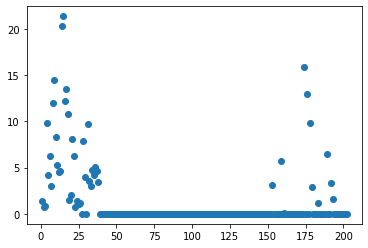

[14, 13, 173, 8, 16, 175, 15, 7, 17, 3, 177, 30]


[14, 13, 173, 8, 16, 175, 15, 7, 17, 3, 177, 30]

<Figure size 432x288 with 0 Axes>

In [7]:
get_indices(num_select, num_feature, file_weights)